In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as st

%matplotlib inline

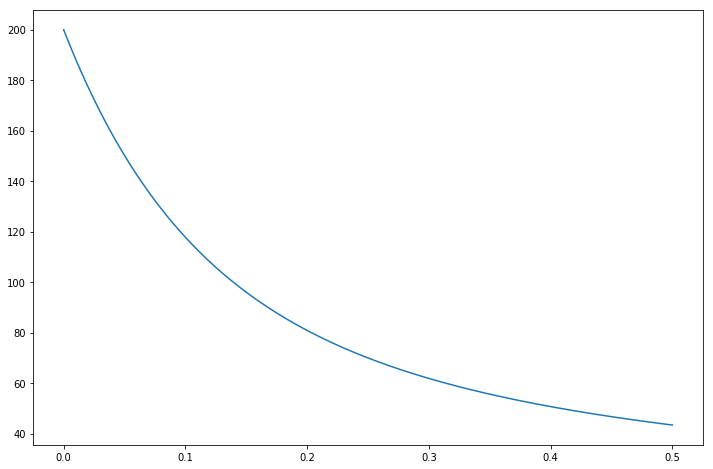

In [21]:
def vanilla_bond(ytm, coupon_rate, ttm, face_value = 100, final_principal = 100, n = 2):
    '''assume semi annual compounding'''
    t = np.arange(ttm * n) / n
    discount_factor = (1 + ytm / n)**t
    coupon_cf = np.sum((face_value * coupon_rate / n) / discount_factor)
    principal_cf = final_principal / (1 + ytm / n)**(ttm * n)
    return  coupon_cf + principal_cf

ytms = np.arange(0, 0.5, 0.0001)
price = np.array([vanilla_bond(ytm, 0.1, 10) for ytm in ytms])

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(ytms, price)

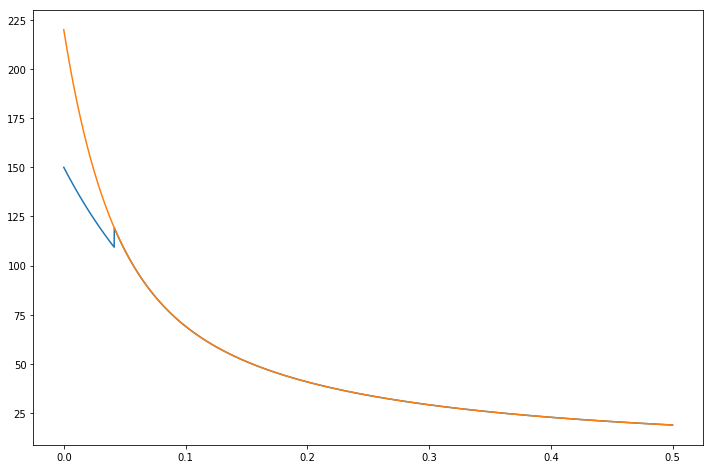

In [40]:
def european_callable_bond(ytm, coupon_rate, bond_maturity, call_price, option_maturity, face_value = 100, final_principal = 100, n = 2):
    price_at_option_maturity = vanilla_bond(ytm, coupon_rate, bond_maturity - option_maturity)
    
    if price_at_option_maturity > call_price:
        price_at_option_maturity = call_price
        return vanilla_bond(ytm, coupon_rate, option_maturity, final_principal = price_at_option_maturity) 
    else:
        return vanilla_bond(ytm, coupon_rate, bond_maturity, face_value, final_principal, n)
    #return price_at_option_maturity
    
    
ytms = np.arange(0, 0.5, 0.0001)
price = np.array([european_callable_bond(ytm, 0.04, 30, 110, 10) for ytm in ytms])
vanilla_price = np.array([vanilla_bond(ytm, 0.04, 30) for ytm in ytms])


fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(111)
ax1.plot(ytms, price)
ax1.plot(ytms, vanilla_price)

In [232]:
def vasicek(r0, K, theta, sigma, T, N_split, N_sample = 1000):
    dt = T/float(N_split)
    rate = np.ones(N_sample) * r0
    for i in range(N_split):
        dr = K*(theta-rate)*dt + sigma*np.random.normal(size = N_sample)
        rate = rate + dr
    return rate

def exact_zcb(theta, kappa, sigma, tau, r0=0.):
    B = (1 - np.exp(-kappa*tau)) / kappa
    A = np.exp((theta-(sigma**2)/(2*(kappa**2))) * (B-tau) - (sigma**2)/(4*kappa)*(B**2))
    return A * np.exp(-r0*B)

def calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price, N_split, N_sample, T, t, n = 2, face_value=100, call = True):
    time_step = 1 / n
    r1 = vasicek(r0, kappa, theta, sigma, t, N_split, N_sample)
    price_1 = np.zeros(N_sample)
    for time in np.arange(time_step, T - t + time_step, time_step):
        price_1 = price_1 + (coupon * face_value / n) * exact_zcb(theta, kappa, sigma, time, r1)
    price_1 = price_1 + face_value * exact_zcb(theta, kappa, sigma, T - t, r1)
    
    
    price_1_est = np.sum(price_1) / N_sample

    
    # compare with K
    if call:
        price_1_est = min(price_1_est, call_price)
    
    # discount back to 0
    return price_1_est * exact_zcb(theta, kappa, sigma, t, r0)

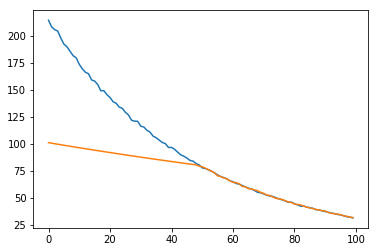

In [239]:
# 10 years, option exercise at year 1, 1000 cuts per year
# 4% coupon per year
r0 = 0.02
K = 0.2
kappa = 0.02
theta = 0.01
sigma = 0.012

T = 10
t = 1
split = 10
coupon = 0.02
face_value = 100
call_price = 101

N = 1000
n = 2

price = []
initial_r = np.arange(0, 0.1, 0.001)
for r0 in initial_r:
    price.append(calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price = 101, N_split = 10, N_sample= 10000, T = 30, t = 5, call = False))
    
    
price_call = []
for r0 in initial_r:
    price_call.append(calc_Callable_Price(r0, coupon, K, theta, sigma, kappa, call_price = 101, N_split = 10, N_sample= 10000, T = 30, t = 5))
    
    
price = np.array(price)
price_call = np.array(price_call)

#fig = plt.figure(figsize = (12, 8))
#ax = fig.add_subplot(111)
#ax.plot(initial_r, price)

plt.plot(price)
plt.plot(price_call)

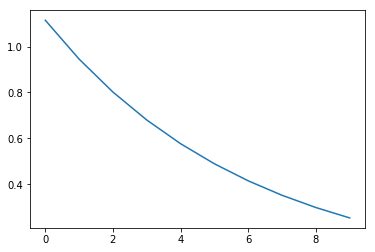

In [205]:
e = exact_zcb(theta, kappa, sigma, 20, np.arange(0, 0.1, 0.01))
plt.plot(e)

In [ ]:
def vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):
    np.random.seed(seed)
    dt = T/float(N)
    rates = [r0]
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + sigma*np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

In [96]:
def vasicek(r0, K, theta, sigma, T=1., N=10):
    dt = T/float(N)
    rates = np.ones(10) * 0.2
    
    for i in range(N):
        b = sigma*np.random.normal(size = 10)
        print(b)
        dr = K*(theta-rates)*dt + b
        rates = rates + dr
    return range(N+1), rates

vasicek(r0, kappa, theta, sigma, T=1., N=1000)

[ 0.01047624  0.01231514  0.00835753 -0.00029688  0.00351976  0.01181149
 -0.02299861 -0.00291112 -0.00504414  0.00109787]
[-0.00040287  0.01388384  0.00335553 -0.00685295  0.01355495  0.00083289
  0.02782116 -0.00135243 -0.00655807  0.00458776]
[-0.01677878  0.00375072  0.01386386 -0.00253514 -0.01341168 -0.00355173
  0.01207956 -0.00878329 -0.00049264 -0.01722374]
[ 0.005756   -0.00604851 -0.0314323   0.01044985  0.01061296 -0.00155513
  0.00326565 -0.00394467  0.01132016  0.01124004]
[-0.01360228  0.00923443  0.0116802   0.02763972 -0.00188347 -0.01277474
 -0.00854321 -0.00636771 -0.01094608  0.0074172 ]
[ 0.00889497  0.01022504 -0.02548478  0.01974007 -0.01655736  0.01712302
  0.01624547 -0.01721883 -0.00445761 -0.00674085]
[ 0.01318947  0.00140882  0.00372673  0.03594226  0.00690201  0.00340028
  0.00894248  0.02206897 -0.01025268 -0.01487955]
[ 0.01327485  0.01004735 -0.02074201  0.02534272  0.00083894 -0.00119051
 -0.00374659  0.00143137 -0.00037034 -0.00266456]
[-0.0081153  -0.

 -0.03168607 -0.01235417  0.00237289 -0.00815958]
[ 0.00367594 -0.00304618 -0.00389754 -0.00169434  0.01051475 -0.00957454
 -0.00350548  0.00373327  0.00345393  0.01041907]
[ 0.0153936   0.02566276  0.00894107  0.00749921  0.0134215   0.00286276
  0.00193197  0.00872154  0.02187094  0.00801162]
[-0.01190963 -0.02695267 -0.00751883  0.02410513  0.02309015  0.01629136
  0.00976186 -0.00628942 -0.02331418 -0.02447211]
[-0.00630515  0.01017213 -0.01878167  0.01392338 -0.01713613 -0.00738447
  0.00436459 -0.00687622 -0.01317078 -0.01235735]
[ 0.00861302 -0.00497091  0.00622828 -0.01931035 -0.02327857 -0.00800655
  0.00337605 -0.00336836  0.01190504 -0.01469353]
[-0.02379268  0.01620371 -0.00781763 -0.00310245  0.00638323  0.02092306
 -0.01679004  0.00304782  0.00317501  0.003804  ]
[ 0.00386033  0.00029457 -0.00448606  0.00057392 -0.02087126  0.01202309
 -0.01254298 -0.00538855  0.01310367 -0.01028749]
[-0.00200343 -0.01821986  0.00176124  0.00580503 -0.00472409 -0.00900235
  0.01487924 -0.

(range(0, 1001),
 array([ 0.5273533 ,  0.45450576,  0.34546506, -0.17250582,  0.26398312,
         0.96383712,  0.44262838,  0.35231474,  0.00380475,  0.07354695]))

In [121]:
 exact_zcb(theta, kappa, sigma, 0.5, r0=0.)

0.99997806097070652

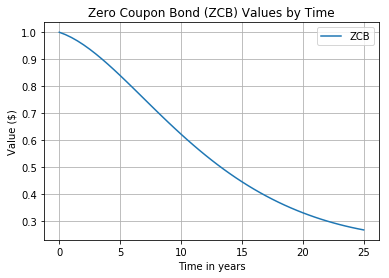

In [6]:



Ts = np.r_[0.0:25.5:0.5]
zcbs = [exact_zcb(0.5, 0.02, 0.03, t, 0.015) for t in Ts]

plt.title("Zero Coupon Bond (ZCB) Values by Time")
plt.plot(Ts, zcbs, label='ZCB')
plt.ylabel("Value ($)")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)
plt.show()

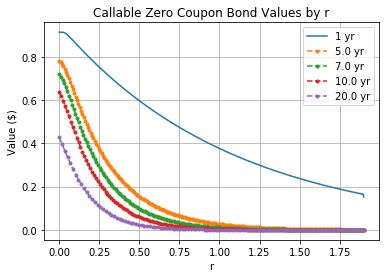

In [12]:
class VasicekCZCB:
    
    def __init__(self):
        self.norminv = st.distributions.norm.ppf
        self.norm = st.distributions.norm.cdf        

    def vasicek_czcb_values(self, r0, R, ratio, T, sigma, kappa,
                            theta, M, prob=1e-6,
                            max_policy_iter=10,
                            grid_struct_const=0.25, rs=None):
        r_min, dr, N, dtau = \
            self.vasicek_params(r0, M, sigma, kappa, theta,
                                T, prob, grid_struct_const, rs)
        r = np.r_[0:N]*dr + r_min
        v_mplus1 = np.ones(N)

        for i in range(1, M+1):
            K = self.exercise_call_price(R, ratio, i*dtau)
            eex = np.ones(N)*K
            subdiagonal, diagonal, superdiagonal = \
                self.vasicek_diagonals(sigma, kappa, theta,
                                       r_min, dr, N, dtau)
            v_mplus1, iterations = \
                self.iterate(subdiagonal, diagonal, superdiagonal,
                             v_mplus1, eex, max_policy_iter)
        return r, v_mplus1

    def vasicek_params(self, r0, M, sigma, kappa, theta, T,
                       prob, grid_struct_const=0.25, rs=None):
        (r_min, r_max) = (rs[0], rs[-1]) if not rs is None \
            else self.vasicek_limits(r0, sigma, kappa,
                                     theta, T, prob)
        dt = T/float(M)
        N = self.calculate_N(grid_struct_const, dt,
                             sigma, r_max, r_min)
        dr = (r_max-r_min)/(N-1)
        return r_min, dr, N, dt

    def calculate_N(self, max_structure_const, dt,
                    sigma, r_max, r_min):
        N = 0
        while True:
            N += 1
            grid_structure_interval = dt*(sigma**2)/(
                ((r_max-r_min)/float(N))**2)
            if grid_structure_interval > max_structure_const:
                break

        return N

    def vasicek_limits(self, r0, sigma, kappa,
                       theta, T, prob=1e-6):
        er = theta+(r0-theta)*math.exp(-kappa*T)
        variance = (sigma**2)*T if kappa==0 else \
                    (sigma**2)/(2*kappa)*(1-math.exp(-2*kappa*T))
        stdev = math.sqrt(variance)
        r_min = self.norminv(prob, er, stdev)
        r_max = self.norminv(1-prob, er, stdev)
        return r_min, r_max

    def vasicek_diagonals(self, sigma, kappa, theta,
                          r_min, dr, N, dtau):
        rn = np.r_[0:N]*dr + r_min
        subdiagonals = kappa*(theta-rn)*dtau/(2*dr) - \
                       0.5*(sigma**2)*dtau/(dr**2)
        diagonals = 1 + rn*dtau + sigma**2*dtau/(dr**2)
        superdiagonals = -kappa*(theta-rn)*dtau/(2*dr) - \
                         0.5*(sigma**2)*dtau/(dr**2)

        # Implement boundary conditions.
        if N > 0:
            v_subd0 = subdiagonals[0]
            superdiagonals[0] = superdiagonals[0] - \
                                subdiagonals[0]
            diagonals[0] += 2*v_subd0
            subdiagonals[0] = 0

        if N > 1:
            v_superd_last = superdiagonals[-1]
            superdiagonals[-1] = superdiagonals[-1] - \
                                 subdiagonals[-1]
            diagonals[-1] += 2*v_superd_last
            superdiagonals[-1] = 0

        return subdiagonals, diagonals, superdiagonals

    def check_exercise(self, V, eex):
        return V > eex

    def exercise_call_price(self, R, ratio, tau):
        K = ratio*np.exp(-R*tau)
        return K

    def vasicek_policy_diagonals(self, subdiagonal, diagonal,
                                 superdiagonal, v_old, v_new,
                                 eex):
        has_early_exercise = self.check_exercise(v_new, eex)
        subdiagonal[has_early_exercise] = 0
        superdiagonal[has_early_exercise] = 0
        policy = v_old/eex
        policy_values = policy[has_early_exercise]
        diagonal[has_early_exercise] = policy_values
        return subdiagonal, diagonal, superdiagonal

    def iterate(self, subdiagonal, diagonal, superdiagonal,
                v_old, eex, max_policy_iter=10):
        v_mplus1 = v_old
        v_m = v_old
        change = np.zeros(len(v_old))
        prev_changes = np.zeros(len(v_old))

        iterations = 0
        while iterations <= max_policy_iter:
            iterations += 1

            v_mplus1 = self.tridiagonal_solve(subdiagonal,
                                              diagonal,
                                              superdiagonal,
                                              v_old)
            subdiagonal, diagonal, superdiagonal = \
                self.vasicek_policy_diagonals(subdiagonal,
                                              diagonal,
                                              superdiagonal,
                                              v_old,
                                              v_mplus1,
                                              eex)

            is_eex = self.check_exercise(v_mplus1, eex)
            change[is_eex] = 1

            if iterations > 1:
                change[v_mplus1 != v_m] = 1

            is_no_more_eex = False if True in is_eex else True
            if is_no_more_eex:
                break

            v_mplus1[is_eex] = eex[is_eex]
            changes = (change == prev_changes)

            is_no_further_changes = all((x == 1) for x in changes)
            if is_no_further_changes:
                break

            prev_changes = change
            v_m = v_mplus1

        return v_mplus1, (iterations-1)

    def tridiagonal_solve(self, a, b, c, d):
        nf = len(a)  # Number of equations
        ac, bc, cc, dc = \
            map(np.array, (a, b, c, d))  # Copy the array
        for it in np.arange(1, nf):
            mc = ac[it]/bc[it-1]
            bc[it] = bc[it] - mc*cc[it-1] 
            dc[it] = dc[it] - mc*dc[it-1]

        xc = ac
        xc[-1] = dc[-1]/bc[-1]

        for il in np.arange(nf-2, -1, -1):
            xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

        del bc, cc, dc  # Delete variables from memory

        return xc

if __name__ == "__main__":
    r0 = 0.1
    R = 0.04
    ratio = 0.95
    sigma = 0.03
    kappa = 0.15
    theta = 0.05
    prob = 1e-6
    M = 250
    max_policy_iter=10
    grid_struct_interval = 0.25
    rs = np.r_[0.0:2.0:0.1]

    Vasicek = VasicekCZCB()
    r, vals = Vasicek.vasicek_czcb_values(r0, R, ratio, 1.,
                                          sigma, kappa, theta,
                                          M, prob,
                                          max_policy_iter,
                                          grid_struct_interval,
                                          rs)
    import matplotlib.pyplot as plt
    plt.title("Callable Zero Coupon Bond Values by r")
    plt.plot(r, vals, label='1 yr')

    for T in [5., 7., 10., 20.]:
        r, vals = \
            Vasicek.vasicek_czcb_values(r0, R, ratio, T,
                                        sigma, kappa,
                                        theta, M, prob,
                                        max_policy_iter,
                                        grid_struct_interval,
                                        rs)
        plt.plot(r, vals, label=str(T)+' yr',
                 linestyle="--", marker=".")

    plt.ylabel("Value ($)")
    plt.xlabel("r")
    plt.legend()
    plt.grid(True)
    plt.show()

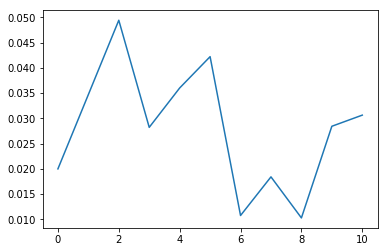

In [226]:
def vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):
    #np.random.seed(seed)
    dt = T/float(N)
    rates = [r0]
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + sigma*np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

x, y = vasicek(0.02, K, theta, sigma, T=1., N=10, seed = 10000)
plt.plot(x, y)

TypeError: vasicek() got an unexpected keyword argument 'N'

In [209]:
def exact_zcb(theta, kappa, sigma, tau, r0=0.):
    B = (1 - np.exp(-kappa*tau)) / kappa
    A = np.exp((theta-(sigma**2)/(2*(kappa**2))) * (B-tau) - (sigma**2)/(4*kappa)*(B**2))
    return A * np.exp(-r0*B)

exact_zcb(0.5, 0.02, 0.03, 1, r0=0.4)

0.66975346588117823